In [0]:
!pip install -U -q pyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
#authenticate
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn import metrics
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

In [0]:
train_downloaded = drive.CreateFile({'id':'10e7gVXoEjOM-cZlSzcWQhumwvR8KpeKa'})
train_downloaded.GetContentFile('train.csv')
test_downloaded = drive.CreateFile({'id':'1H1rooH_VRzn1LS2yJUk94U4Rvi9-NpMA'})
test_downloaded.GetContentFile('test.csv')

In [211]:
train = pd.read_csv('train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [212]:
test = pd.read_csv("test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


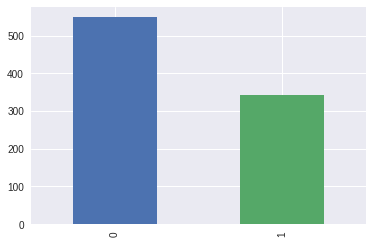

In [213]:
train['Survived'].value_counts().plot.bar()

In [214]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [215]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [216]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [217]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [218]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [219]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [220]:
train.groupby(['Sex' , 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

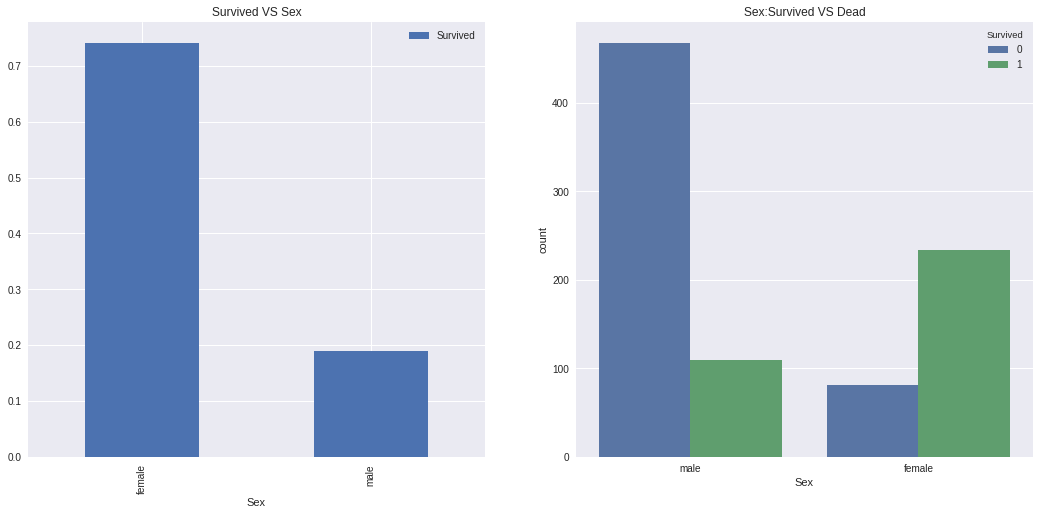

In [221]:
f , ax  = plt.subplots(1, 2 ,figsize=(18 , 8))
train[['Sex' , 'Survived']].groupby('Sex').mean().plot.bar(ax = ax[0])
ax[0].set_title('Survived VS Sex')
sns.countplot('Sex' , hue = 'Survived'  , data = train , ax= ax[1])
ax[1].set_title('Sex:Survived VS Dead')
plt.show()

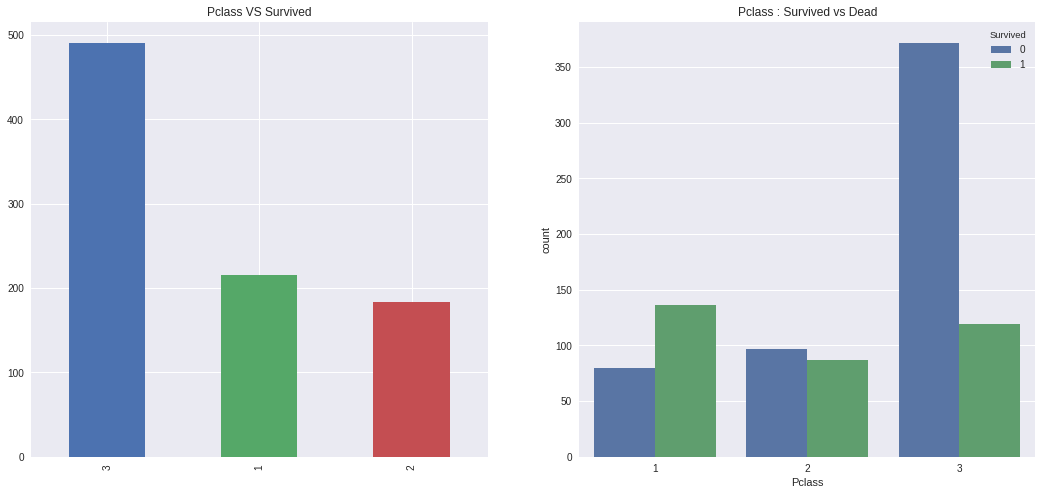

In [222]:
f,ax = plt.subplots(1 , 2  , figsize=(18 , 8))
train['Pclass'].value_counts().plot.bar(ax = ax[0])
ax[0].set_title('Pclass VS Survived')
sns.countplot('Pclass' , hue='Survived' , data = train ,ax = ax[1])
ax[1].set_title('Pclass : Survived vs Dead')
plt.show()

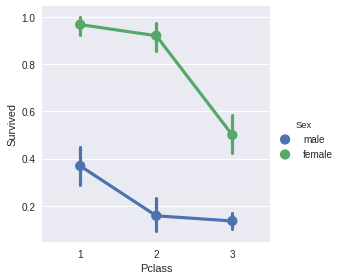

In [223]:
sns.factorplot('Pclass' , 'Survived' , hue = 'Sex' , data =train)
plt.show()

In [0]:
train['Initials'] = 0
for i in train:
  train['Initials'] = train.Name.str.extract('([A-Za-z]+)\.')

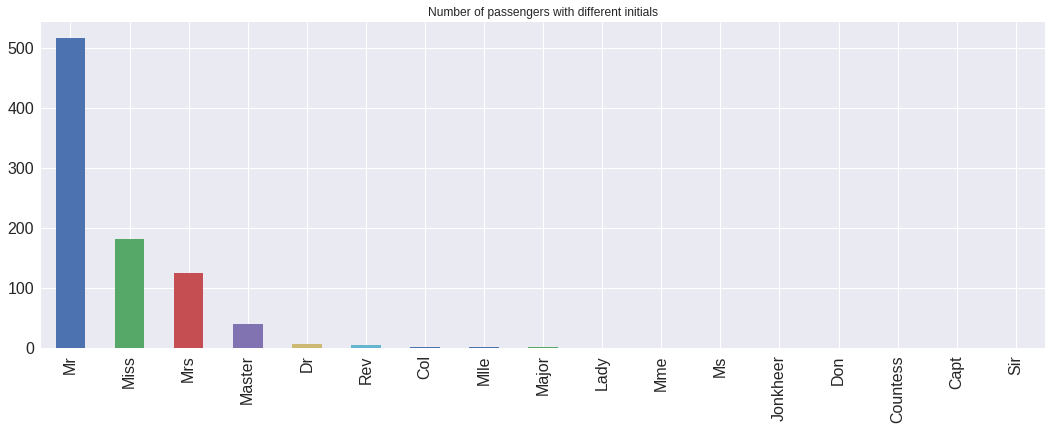

In [225]:
train['Initials'].value_counts().plot.bar(figsize = (18 , 6) , fontsize = 16 ,title = 'Number of passengers with different initials')

In [0]:
train['Initials'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [227]:
train.groupby('Initials')['Age'].mean()

Initials
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

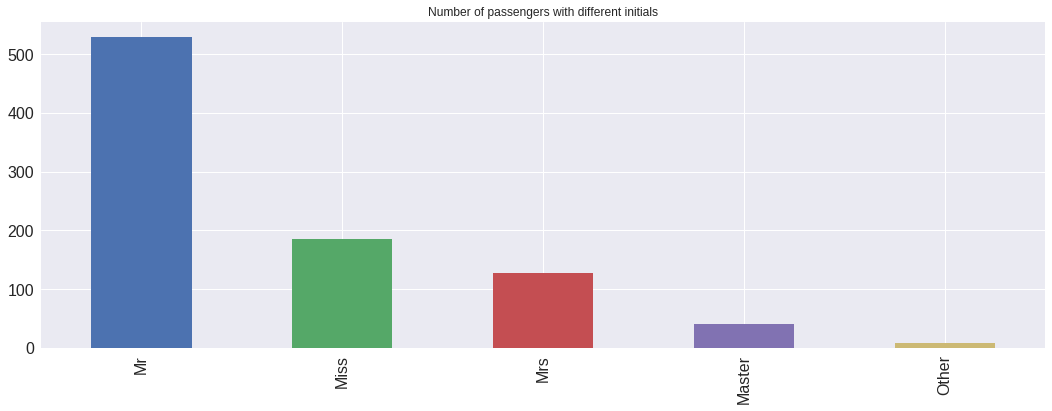

In [228]:
train['Initials'].value_counts().plot.bar(figsize = (18 , 6) , fontsize = 16 ,title = 'Number of passengers with different initials')

In [0]:
## Assigning the NaN Values with the Ceil values of the mean ages
train.loc[(train.Age.isnull())&(train.Initials=='Mr'),'Age']=33
train.loc[(train.Age.isnull())&(train.Initials=='Mrs'),'Age']=36
train.loc[(train.Age.isnull())&(train.Initials=='Master'),'Age']=5
train.loc[(train.Age.isnull())&(train.Initials=='Miss'),'Age']=22
train.loc[(train.Age.isnull())&(train.Initials=='Other'),'Age']=46

In [230]:
train['Age'].isnull().any()

False

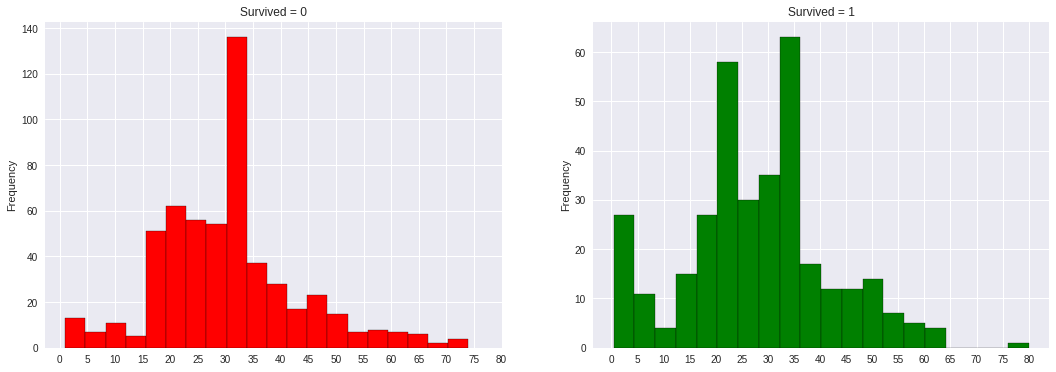

In [231]:
f, ax  = plt.subplots(1 , 2,figsize = (18 ,6))
train[train['Survived']==0]['Age'].plot.hist(ax= ax[0] , bins = 20,edgecolor = 'black',color ='red')
ax[0].set_title('Survived = 0')
x1 = list(range(0 , 85 , 5))
ax[0].set_xticks(x1)
train[train['Survived']==1]['Age'].plot.hist(ax=ax[1] , bins = 20 , edgecolor = 'black' , color = 'green')
ax[1].set_title('Survived = 1')
x2 = list(range(0 , 85 , 5))
ax[1].set_xticks(x2)
plt.show()

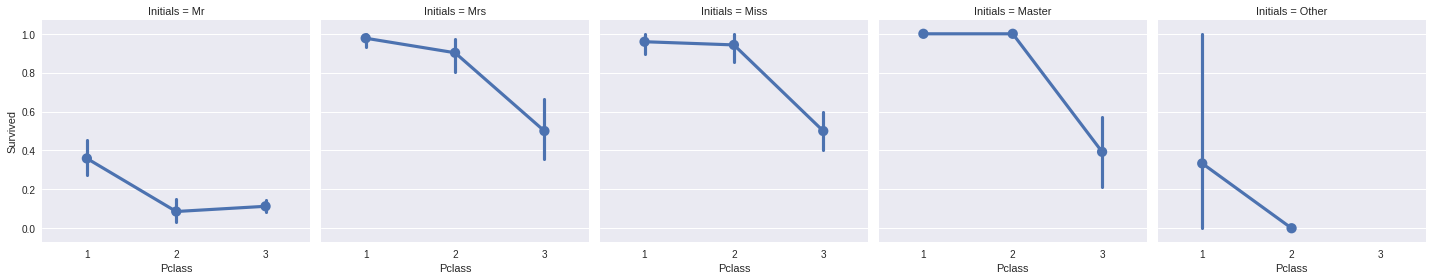

In [232]:
sns.factorplot('Pclass','Survived',col='Initials',data=train)
plt.show()

In [233]:
pd.crosstab([train.Embarked,train.Pclass],[train.Sex,train.Survived],margins=True ).style.background_gradient(cmap='summer_r')

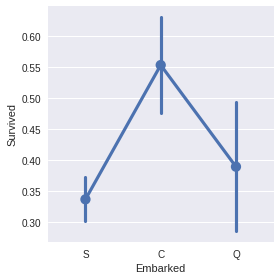

In [234]:
sns.factorplot('Embarked','Survived',data=train)

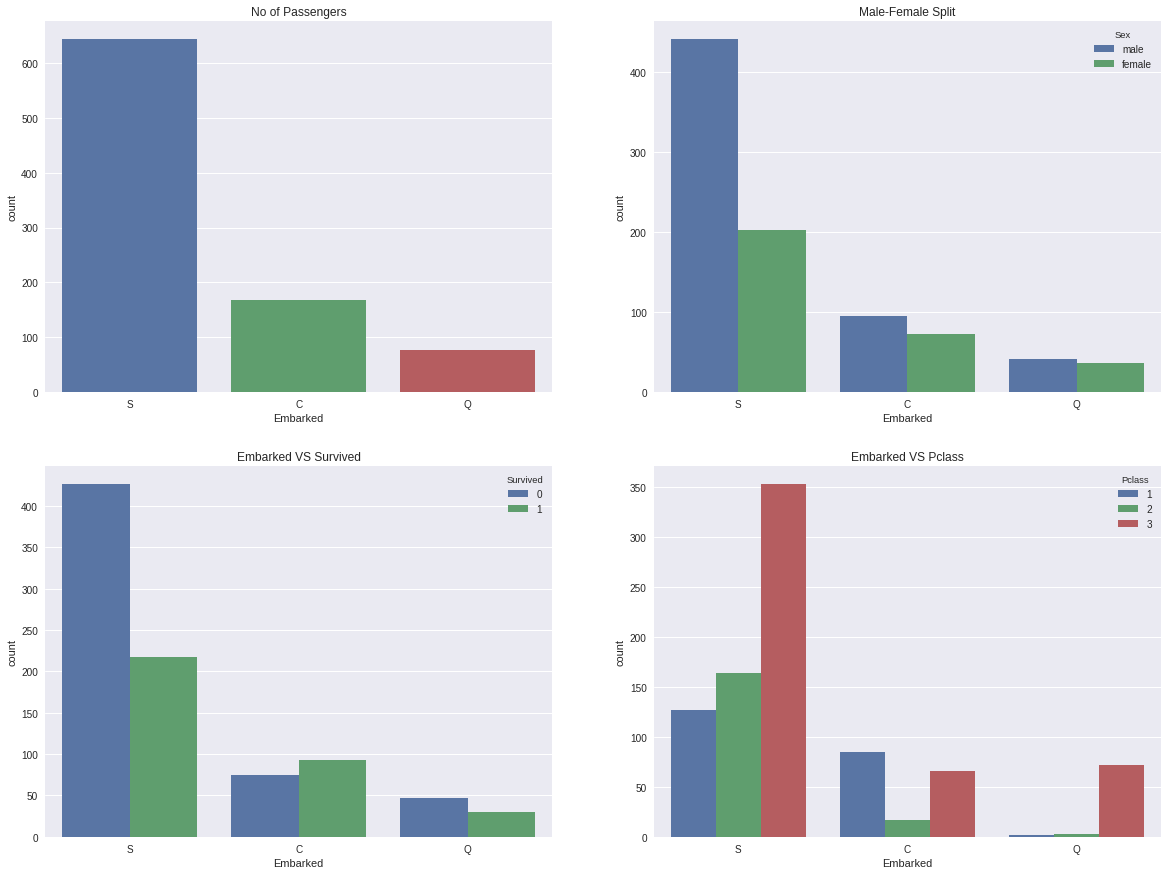

In [235]:
f , ax  = plt.subplots(2,2,figsize = (20 , 15))
sns.countplot('Embarked' , data = train , ax = ax[0 , 0])
ax[0,0].set_title('No of Passengers')
sns.countplot('Embarked' , hue = 'Sex' , data =train , ax=ax[ 0 , 1])
ax[0 , 1].set_title('Male-Female Split')
sns.countplot('Embarked' , hue = 'Survived' , data=train , ax=ax[1 ,0])
ax[1 , 0].set_title('Embarked VS Survived')
sns.countplot('Embarked' , hue = 'Pclass' , data = train , ax= ax[1 , 1])
ax[1,1].set_title('Embarked VS Pclass')
plt.show()

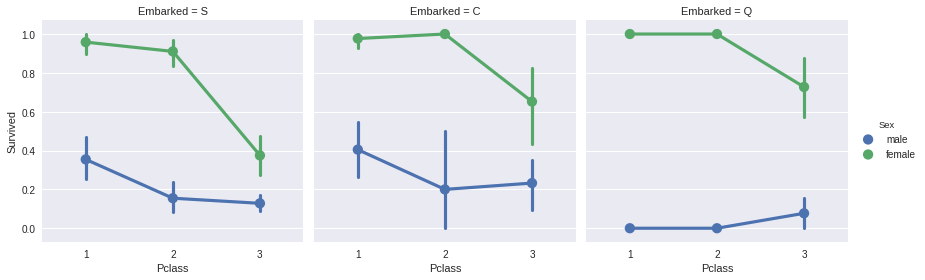

In [236]:
sns.factorplot('Pclass','Survived',hue='Sex',col='Embarked',data=train)
plt.show()

In [0]:
train['Embarked'].fillna('S',inplace  = True)

In [238]:
train['Embarked'].isnull().any()

False

In [239]:
pd.crosstab([train.SibSp],train.Survived).style.background_gradient(cmap='summer_r')

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


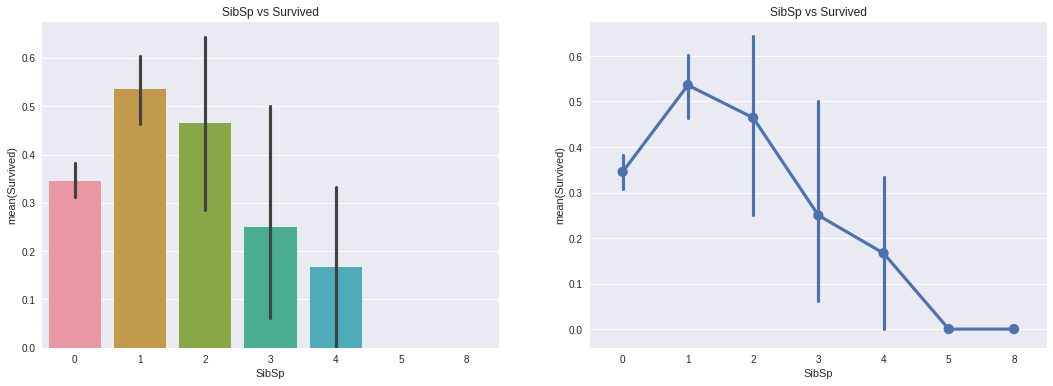

In [240]:
f, ax  = plt.subplots(1 , 2 , figsize = (18, 6))
sns.barplot('SibSp' , 'Survived' ,data =train, ax= ax[0])
ax[0].set_title('SibSp vs Survived')
sns.factorplot('SibSp' , 'Survived' , data =train ,ax =  ax[1])
ax[1].set_title('SibSp vs Survived')
plt.close(2)
plt.show()

In [241]:
pd.crosstab(train.SibSp,train.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
SibSp,,,
0,137,120,351
1,71,55,83
2,5,8,15
3,3,1,12
4,0,0,18
5,0,0,5
8,0,0,7


In [242]:
pd.crosstab(train.SibSp,train.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
SibSp,,,
0,137,120,351
1,71,55,83
2,5,8,15
3,3,1,12
4,0,0,18
5,0,0,5
8,0,0,7


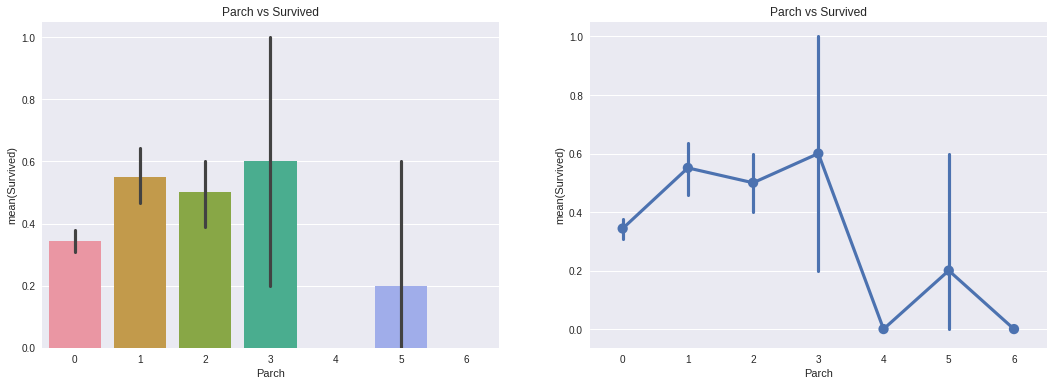

In [243]:
f,ax=plt.subplots(1,2,figsize=(18,6))
sns.barplot('Parch','Survived',data=train,ax=ax[0])
ax[0].set_title('Parch vs Survived')
sns.factorplot('Parch','Survived',data=train,ax=ax[1])
ax[1].set_title('Parch vs Survived')
plt.close(2)
plt.show()

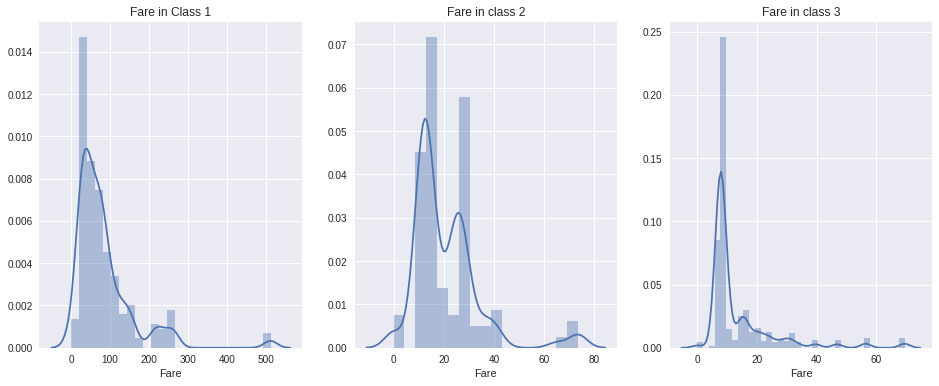

In [244]:
f, ax = plt.subplots(1 , 3 ,figsize = (16 , 6))
sns.distplot(train[train['Pclass']==1]['Fare'],ax = ax[0])
ax[0].set_title('Fare in Class 1')
sns.distplot(train[train['Pclass']==2]['Fare'] , ax=ax[1])
ax[1].set_title('Fare in class 2')
sns.distplot(train[train['Pclass']==3]['Fare'] , ax = ax[2])
ax[2].set_title('Fare in class 3')
plt.show()

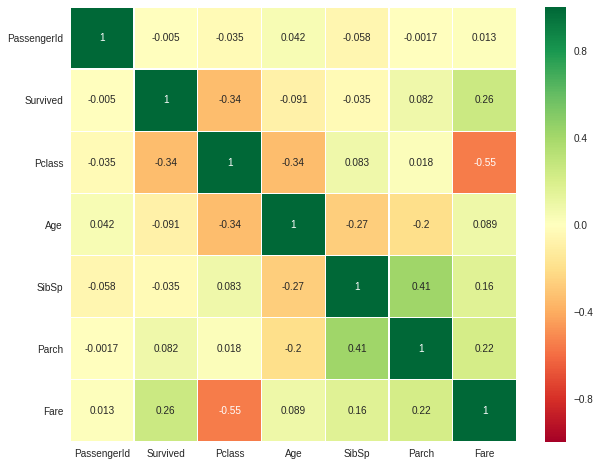

In [245]:
sns.heatmap(train.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [246]:
train['Age_Group'] = 0
train.loc[train['Age']<16 , 'Age_Group']=0
train.loc[(train['Age']>=16)&(train['Age']<32) , 'Age_Group']=1
train.loc[(train['Age']>=32)&(train['Age']<48) , 'Age_Group']=2
train.loc[(train['Age']>=48)&(train['Age']<64),'Age_Group'] = 3
train.loc[train['Age']>=64,'Age_Group'] = 4
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initials,Age_Group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,2


In [247]:
train['Age_Group'].value_counts().to_frame().style.background_gradient(cmap='summer')

,Age_Group
1,381
2,334
0,87
3,76
4,13


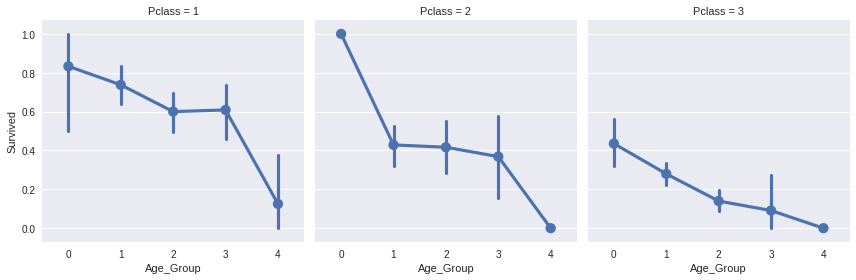

In [248]:
sns.factorplot('Age_Group','Survived',data=train,col='Pclass')
plt.show()

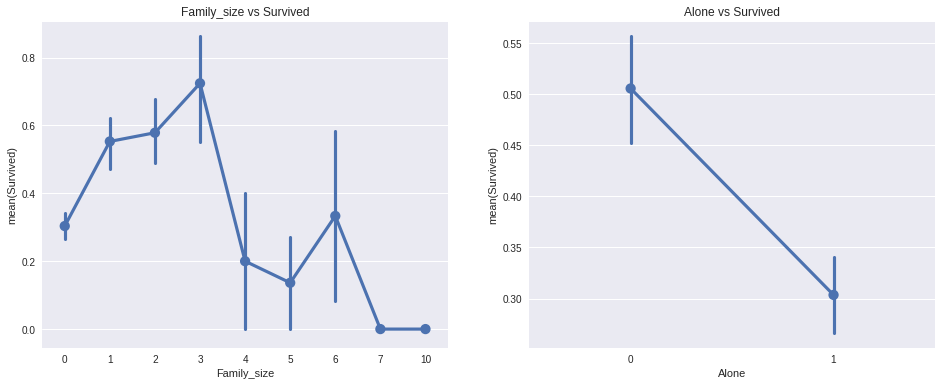

In [249]:
train['Family_size'] = 0
train['Family_size']= train['SibSp']+train['Parch']
train['Alone']=0
train.loc[train['Family_size']==0 , 'Alone'] = 1

f,ax = plt.subplots(1 , 2 ,figsize=(16 , 6))
sns.factorplot('Family_size' , 'Survived' , data =train , ax=ax[0])
ax[0].set_title('Family_size vs Survived')
sns.factorplot('Alone' , 'Survived' , data = train , ax =ax[1])
ax[1].set_title('Alone vs Survived')
plt.close(2)
plt.close(3)
plt.show()

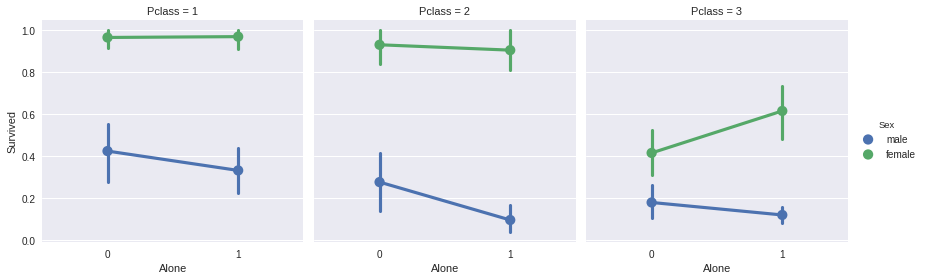

In [250]:
sns.factorplot('Alone' , 'Survived' , hue = 'Sex' , data = train, col = 'Pclass')
plt.show()

In [251]:
train['Fare_Range'] = pd.qcut(train['Fare'] , 4)
train.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Fare_Range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


In [0]:
train['Fare_cat'] = 0
train.loc[train['Fare']<=7.91 , 'Fare_cat'] = 0
train.loc[(train['Fare']>7.31)&(train['Fare']<=14.45) , 'Fare_cat']=1
train.loc[(train['Fare']>14.45)&(train['Fare']<=31),'Fare_cat']=2
train.loc[(train['Fare']>31) , 'Fare_cat']=3

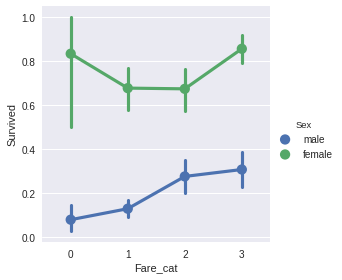

In [253]:
sns.factorplot('Fare_cat','Survived',data=train,hue='Sex')
plt.show()

In [0]:
train['Sex'].replace(['male','female'],[0,1],inplace=True)
train['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
train['Initials'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

In [255]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null int64
Initials       891 non-null int64
Age_Group      891 non-null int64
Family_size    891 non-null int64
Alone          891 non-null int64
Fare_Range     891 non-null category
Fare_cat       891 non-null int64
dtypes: category(1), float64(2), int64(12), object(3)
memory usage: 119.3+ KB


In [0]:
train.drop(['Name','Age','Ticket','Fare','Cabin','Fare_Range','PassengerId'],axis=1,inplace=True)


In [257]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null int64
SibSp          891 non-null int64
Parch          891 non-null int64
Embarked       891 non-null int64
Initials       891 non-null int64
Age_Group      891 non-null int64
Family_size    891 non-null int64
Alone          891 non-null int64
Fare_cat       891 non-null int64
dtypes: int64(11)
memory usage: 76.6 KB


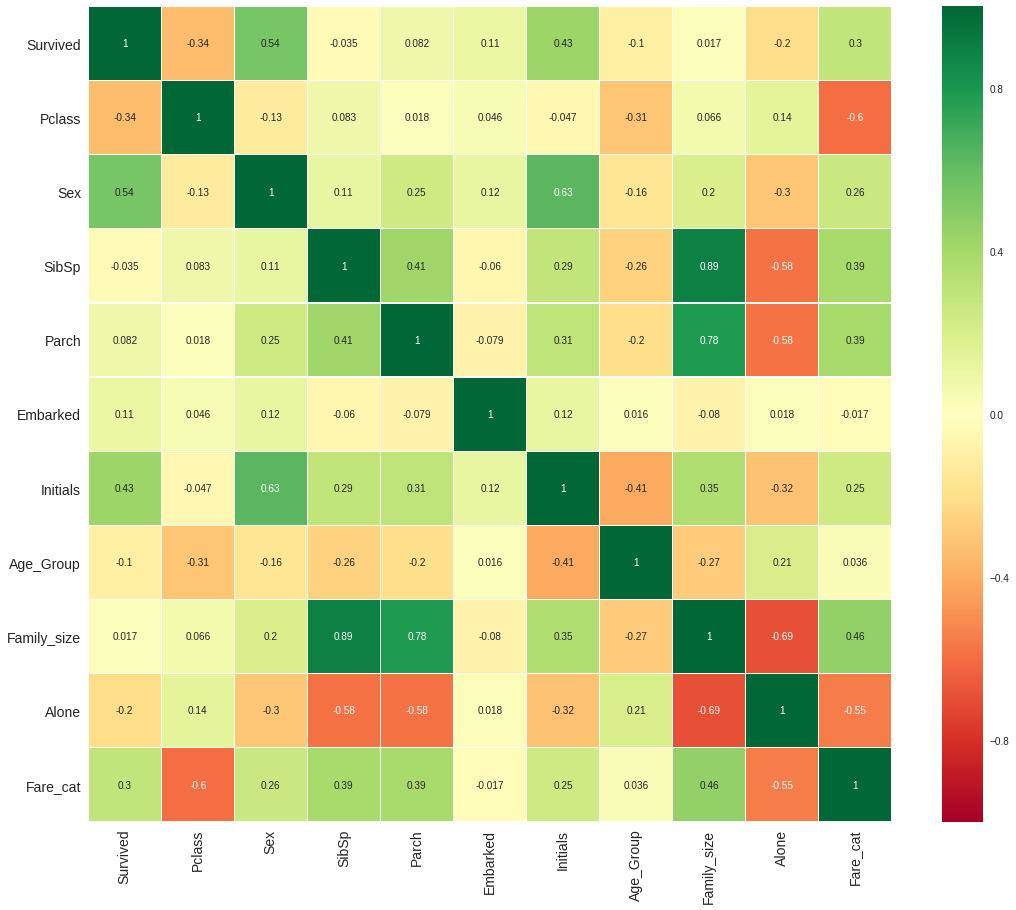

In [258]:
sns.heatmap(train.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [0]:
training , testing =train_test_split(train , test_size = 0.25 , random_state = 0)
train_x = training[training.columns[1:]]
train_y =training[training.columns[:1]]
test_x = testing[testing.columns[1:]]
test_y = testing[training.columns[:1]]
x= train[train.columns[1:]]
y =train['Survived']

In [261]:
model=RandomForestClassifier(n_estimators=100)
model.fit(train_x,train_y)
prediction=model.predict(test_x)
print('The accuracy of the Random Forests is',metrics.accuracy_score(prediction,test_y))

The accuracy of the Random Forests is 0.8340807174887892


In [0]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict



In [0]:
kfold = KFold(n_splits = 10 ,random_state = 1998)

In [264]:
cv_result = cross_val_score(model , x, y ,cv =kfold , scoring ='accuracy')
print(cv_result.mean() ,
cv_result.std())

0.8036204744069912 0.020544701351164752


Text(0.5, 1.0, 'Random Forest Confusion Matrix')

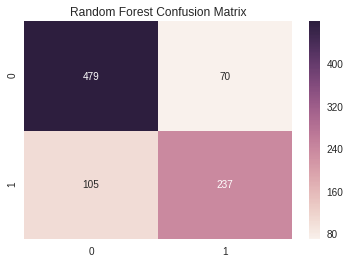

In [265]:
from sklearn.metrics import confusion_matrix

y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100),x,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='2.0f')
plt.title('Random Forest Confusion Matrix')
